### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import math
import seaborn as sns

# Import Custom Module
import OeconToolbox as ott

%load_ext autoreload
%autoreload 2
%matplotlib inline

### [OPTIONAL] Set Matplotlib Style

In [2]:
matplotlib.style.use('default')

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 10})
matplotlib.path.should_simplify = True

sns.set_style("ticks")

cm = 1/2.54
textwidth = 13.998 / 2.54

## Import Cumulative Default Table

In [3]:
DefTable = pd.read_excel("CumulativeDefaultTable.xlsx",header=[0],index_col=[0],skipfooter=5,usecols="A:K")
DefTable.round(2)

,1,2,3,4,5,6,7,8,9,10
AAA,0.00,0.03,0.10,0.19,0.27,0.37,0.41,0.46,0.52,0.58
AA,0.02,0.06,0.11,0.21,0.30,0.41,0.49,0.56,0.63,0.70
A,0.05,0.13,0.22,0.33,0.46,0.60,0.76,0.90,1.05,1.20
BBB,0.16,0.43,0.75,1.14,1.54,1.94,2.27,2.61,2.94,3.24
BB,0.63,1.93,3.46,4.99,6.43,7.75,8.89,9.90,10.82,11.64
B,3.34,7.80,11.75,14.89,17.35,19.36,20.99,22.31,23.50,24.62


# Simulating a Portfolio of loans
The SPV portfolio consists of $J$ loans from identical corporate issuers with a single class of debt outstanding. The parameters of the issuers is identical to those described in the 'Collateral Dynamics.ipynb' notebook.

## Parameters of the Corporate Issuers

In [4]:
V0 = 100      # Initial Asset Value
rf = .035     # Risk-Free Rate
rm = .105     # Market Return
beta = .8     # Firm CAPM Coefficient
sigma_i = .25 # Idiosyncratic Risk
sigma_m = .14 # Market Risk
ttm = 5       # Time to Maturity of Debt
penalty = 0   # Penalty on prepayment

Auxiliary Calculations

In [5]:
mu = rf + beta * (rm - rf)
sigma = ott.sigma_beta_adj(beta, sigma_m, sigma_i)
face_value = ott.facevalue_from_probability(DefTable.loc["B", ttm] / 100, V0, ttm, mu, sigma)
market_value = ott.mv_bond(V0, face_value, ttm, rf, sigma)
b_loan_yield = ott.zero_yield(market_value,face_value, ttm)
# Results from Collateral Dynamics Notebook
mv_call = 54.71780723807047
b_callable_yield = ott.zero_yield(mv_call,face_value, ttm)

## Parameters of the SPV

In [6]:
J = 125    # number of loans
N = 250000 # Number of simulated portfolios

# Modelling the SPV Dynamics without Prepayment on Collateral Assets

In [7]:
max_spv_cash_flows = face_value * J
initial_market_value = market_value * J
print("The absolute maximum payoff: {0:0.2f} with initial market value: {1:0.2f}".format(max_spv_cash_flows,initial_market_value))

The absolute maximum payoff: 9180.30 with initial market value: 6990.38


Total SPV payoffs (under Q-measure)

In [8]:
SPV_Q, _ = ott.loan_portfolio(j = J,
                              n = N,
                              V = V0,
                              B = face_value,
                              T = ttm,
                              rf = rf,
                              rm = rm,
                              beta = beta,
                              sigmaI = sigma_i,
                              sigmaM = sigma_m,
                              risk_neutral=True,
                              paths=False)

Total SPV payoffs (under P-measure)

In [9]:
SPV_P, M = ott.loan_portfolio(j = J,
                              n = N,
                              V = V0,
                              B = face_value,
                              T = ttm,
                              rf = rf,
                              rm = rm,
                              beta = beta,
                              sigmaI = sigma_i,
                              sigmaM = sigma_m,
                              risk_neutral=False,
                              paths=False)

In [10]:
total, tranches = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    total[i]  = np.quantile(SPV_P, def_prob/100)
    if i == 0 : tranches[i] = np.quantile(SPV_P, def_prob/100)
    else: tranches[i] = np.quantile(SPV_P, def_prob/100) - total[i-1].sum(axis=0)
    i = i + 1
tranches[i] = np.quantile(SPV_P, 1) - total[i-1].sum(axis=0)

## Cash Flows to each Tranche

In [11]:
pd.DataFrame({'Cash Flows':tranches,'Sum':tranches.cumsum(),'Percent of Total':np.divide(tranches,tranches.cumsum()[-1])*100},["AAA","AA","A","BBB","BB","B","Equity"]).round(1)

,Cash Flows,Sum,Percent of Total
AAA,7233.1,7233.1,78.8
AA,32.6,7265.7,0.4
A,125.6,7391.3,1.4
BBB,358.1,7749.4,3.9
BB,442.0,8191.4,4.8
B,317.9,8509.2,3.5
Equity,671.1,9180.3,7.3


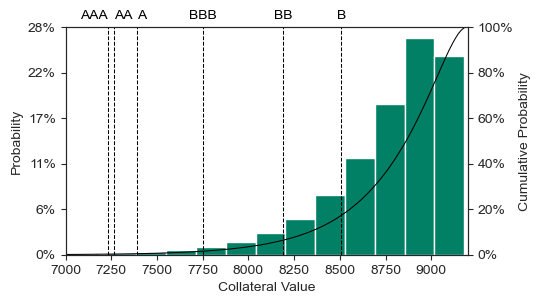

In [12]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=1)
plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()
plt.show()
#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

Data For Scatterplots

In [13]:
SPV_P_small = np.random.RandomState(1234).choice(SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(M,size=2500)

In [14]:
scatter_data = pd.DataFrame({'SPV':SPV_P_small/ max_spv_cash_flows,
                             'Market Factor':M_small / 5,
                             'AAA':ott.clo_payoffs(SPV_P_small,tranches)[0]/ tranches[0],
                             'AA':ott.clo_payoffs(SPV_P_small,tranches)[1]/ tranches[1],
                             'A':ott.clo_payoffs(SPV_P_small,tranches)[2] / tranches[2],
                             'BBB':ott.clo_payoffs(SPV_P_small,tranches)[3] / tranches[3],
                             'BB':ott.clo_payoffs(SPV_P_small,tranches)[4] / tranches[4],
                             'B':ott.clo_payoffs(SPV_P_small,tranches)[5] / tranches[5],
                             'Equity':ott.clo_payoffs(SPV_P_small,tranches)[6]/ tranches[6]})
scatter_data

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.990824,0.249813,1.0,1.0,1.0,1.0,1.0,1.0,0.874467
1,0.982318,0.007552,1.0,1.0,1.0,1.0,1.0,1.0,0.758100
2,0.976469,0.196481,1.0,1.0,1.0,1.0,1.0,1.0,0.678097
3,0.964409,-0.136603,1.0,1.0,1.0,1.0,1.0,1.0,0.513102
4,0.982938,0.328542,1.0,1.0,1.0,1.0,1.0,1.0,0.766591
...,...,...,...,...,...,...,...,...,...
2495,0.979048,0.134932,1.0,1.0,1.0,1.0,1.0,1.0,0.713368
2496,0.968940,0.348749,1.0,1.0,1.0,1.0,1.0,1.0,0.575085
2497,0.983798,0.594158,1.0,1.0,1.0,1.0,1.0,1.0,0.778358
2498,0.939418,-0.309687,1.0,1.0,1.0,1.0,1.0,1.0,0.171217


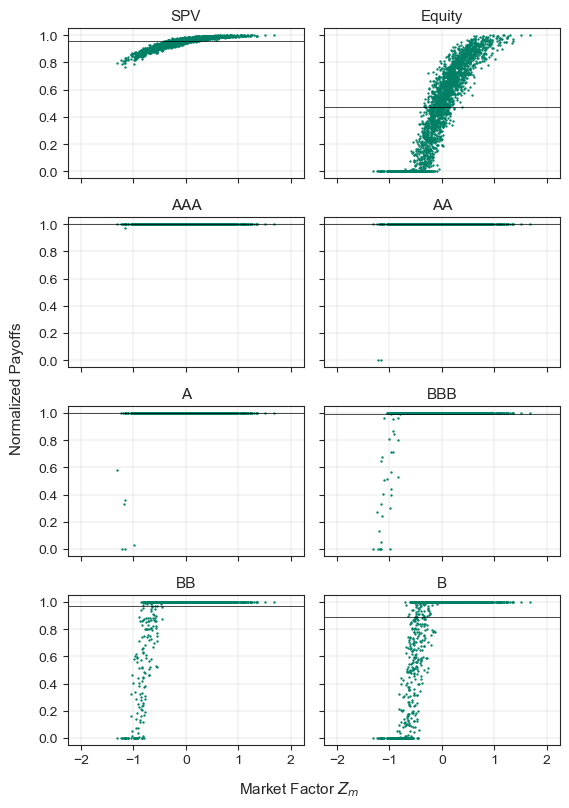

In [15]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1))
    axs[i,j].set_title(tranche, size=11)
    axs[i,j].axhline(scatter_data[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

plt.show()

#fig.savefig("Payoffs.png", bbox_inches='tight', format='png', dpi=600)

In [16]:
no_prepay_tab = DefTable[[ttm]].copy()
no_prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
no_prepay_tab['Face Value'] = (np.quantile(SPV_P, no_prepay_tab['Default Probability']/100) / initial_market_value) * 100
no_prepay_tab.round(2)

,Default Probability,Face Value
AAA,0.27,103.47
AA,0.30,103.94
A,0.46,105.73
BBB,1.54,110.86
BB,6.43,117.18
B,17.35,121.73


In [17]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 131.33


In [18]:
for rating in no_prepay_tab.index:
    no_prepay_tab.loc[rating, 'Market Value'] = (np.minimum(SPV_Q,
                                                            np.quantile(SPV_P,
                                                                        no_prepay_tab.loc[rating, 'Default Probability']/100
                                                                       )).mean() * np.exp(-rf*ttm) / initial_market_value) * 100

Preliminary Table before "tranching"

In [19]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,103.47,86.64
AA,0.30,103.94,87.02
A,0.46,105.73,88.44
BBB,1.54,110.86,92.31
BB,6.43,117.18,96.41
B,17.35,121.73,98.56


Tranching:

In [20]:
no_prepay_tab.loc[:,'Face Value':'Market Value'] = no_prepay_tab.loc[:,'Face Value':'Market Value'] - no_prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
no_prepay_tab.loc['AAA','Face Value'] = (np.quantile(SPV_P, no_prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value) * 100
no_prepay_tab.loc['AAA','Market Value'] = (np.minimum(SPV_Q, np.quantile(SPV_P, no_prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value) * 100
no_prepay_tab['Yield'] = ott.zero_yield(no_prepay_tab['Market Value'], no_prepay_tab['Face Value'], ttm) * 100
no_prepay_tab.loc['Equity','Market Value'] = 100 - no_prepay_tab['Market Value'].sum(axis=0)

In [21]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


In [22]:
WACD = (no_prepay_tab.loc['AAA':'B','Market Value'] * no_prepay_tab.loc['AAA':'B','Yield']).sum()/no_prepay_tab.loc['AAA':'B','Market Value'].sum()
WACD - rf*100

0.6119757806153125

Return on equity analysis

In [23]:
equity_payoffs = ott.clo_payoffs(SPV_P,tranches)[6]

In [24]:
equity_mv = (np.minimum(SPV_Q, np.quantile(SPV_P,1)).mean() - np.minimum(SPV_Q,np.quantile(SPV_P,DefTable.loc['B',5]/100)).mean()) * np.exp(-rf*ttm) 

In [25]:
equity_returns = equity_payoffs/equity_mv#np.where(np.log1p(equity_payoffs/equity_mv)>0,np.log1p(equity_payoffs/equity_mv)-1,0)

<AxesSubplot:ylabel='Frequency'>

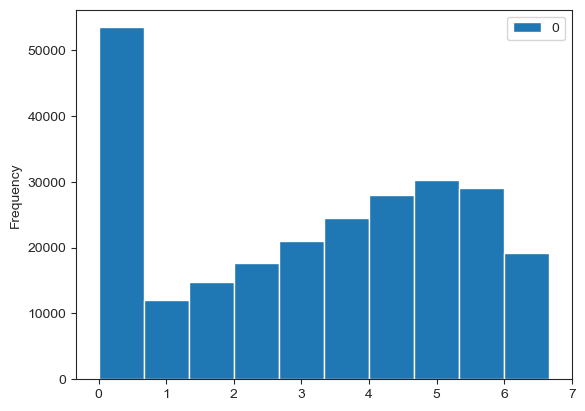

In [26]:
pd.DataFrame(equity_returns).plot(kind='hist')

# Introducing Prepayments on Collateral

In [27]:
#N = 250000

In [28]:
PD, FV, MV, Y = np.zeros(4),np.zeros(4),np.zeros(4),np.zeros(4)

for t in range (1, ttm):
    PD[t-1] = DefTable.loc["B", t] / 100
    FV[t-1] = ott.facevalue_from_probability(PD[t-1], V0, t, mu, sigma)
    MV[t-1] = ott.mv_bond(V0, FV[t-1], t, rf, sigma)
    Y[t-1] = ott.zero_yield(MV[t-1],FV[t-1],t)
    
nc_loans = pd.DataFrame({'PD':PD,'FV':FV,'MV':MV,'Y':Y},index=[4,3,2,1])
nc_loans

,PD,FV,MV,Y
4,0.0334,63.848207,61.319846,0.040405
3,0.0780,64.233368,58.608757,0.045819
2,0.1175,66.827964,57.540211,0.049879
1,0.1489,70.010595,56.717107,0.052643


In [29]:
random_state = np.random.RandomState(1234)
random = random_state.standard_normal(size=(ttm + 1, N, J + 1))

In [30]:
call_barrier = np.flip(face_value * np.exp(-b_loan_yield* np.linspace(0,ttm,ttm+1)) - penalty).reshape((ttm+1,1))

In [31]:
call_barrier

array([[55.92305707],
       [59.05573706],
       [62.36390251],
       [65.85738372],
       [69.54656164],
       [73.44239876]])

In [32]:
# Generate Asset Paths:
def asset_gbm(x,ttm):
        drift = (x - 0.5 * sigma ** 2)
        diffusion = (beta * sigma_m * random[:,:,0].reshape((ttm + 1,N,1))) + (sigma_i * random[:,:,1:])
        increments = drift + diffusion
        increments[0] = 0
        return V0 * np.exp(increments.cumsum(axis=0))

In [33]:
asset_paths_Q = asset_gbm(rf,ttm)
asset_paths_P = asset_gbm(mu,ttm)

In [48]:
asset_paths = asset_paths_Q

In [49]:
nc_loan_paths, call_mat, nc_cfs_mat,  pf_cfs, call_cfs_mat = [np.zeros_like(asset_paths_Q) for _ in range(5)]

In [50]:
face_values_mat = np.ones((N,J)) * face_value
cfs_distributions = np.zeros((ttm,N))

In [51]:
for t in range(0, ttm + 1):
    cond1 = (call_mat[:t,:,:].sum(axis = 0) == 0)
    if t == 0:
        nc_loan_paths[t,:,:] = ott.mv_bond(asset_paths[t,:,:], face_value, (ttm - t), rf, sigma)
    elif t == ttm:
        nc_loan_paths[t,:,:] = np.minimum(asset_paths[t,:,:], face_values_mat[:,:])
        call_mat[t,:,:] = np.where(cond1, 1, 0)
        nc_cfs_mat[t,:,:] = nc_loan_paths[t,:,:]
    else:
        nc_loan_paths[t,:,:] = ott.mv_bond(asset_paths[t,:,:], face_value, (ttm - t), rf, sigma)
        call_mat[t,:,:] = np.where((nc_loan_paths[t,:,:] - call_barrier[t] > 0) & cond1, 1, 0)
        nc_cfs_mat[t,:,:] = face_value * np.exp(-b_loan_yield * (ttm - t)) * call_mat[t,:,:]

In [52]:
pd.DataFrame(nc_loan_paths[:,1,:]).T.head()

,0,1,2,3,4,5
0,55.923057,60.405143,63.465637,68.208353,70.835403,73.442399
1,55.923057,56.707179,65.134331,62.724851,66.209126,59.391516
2,55.923057,52.819171,62.822462,66.679022,70.831822,73.442399
3,55.923057,56.573820,62.031438,61.660553,64.148838,73.442399
4,55.923057,52.714125,62.326489,65.946027,54.466777,39.856744


In [53]:
pd.DataFrame(call_mat[:,1,:]).T.head()

,0,1,2,3,4,5
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
for t in range(1,ttm):
    face_values_mat[:,:] = np.where(call_mat[t,:,:]==1,nc_loans.loc[t,'FV'],face_values_mat[:,:])

In [55]:
nc_loans

,PD,FV,MV,Y
4,0.0334,63.848207,61.319846,0.040405
3,0.0780,64.233368,58.608757,0.045819
2,0.1175,66.827964,57.540211,0.049879
1,0.1489,70.010595,56.717107,0.052643


In [56]:
# Determine Cash Flows to SPV
for t in range(0, ttm + 1):
    if t == ttm:
        call_cfs_mat[t,:,:] = np.minimum(asset_paths[t,:,:], face_value) * call_mat[t,:,:]
    else:
        call_cfs_mat[t,:,:] = face_value * np.exp(-b_callable_yield * (ttm-t)) * call_mat[t,:,:]

In [57]:
# Distributions to Equity
for t in range(1, ttm):
    cfs_distributions[t,:] = np.where(call_mat[t,:,:]==1, call_cfs_mat[t,:,:] - nc_loans.loc[t,'MV'],0).sum(axis=1)

In [58]:
pd.DataFrame(cfs_distributions[:,:]).T

,0,1,2,3,4
0,0.0,84.365078,24.082457,46.740201,63.394597
1,0.0,46.137152,132.453513,93.480402,79.243246
2,0.0,84.365078,36.123685,53.417373,31.697298
3,0.0,105.456348,24.082457,46.740201,23.772974
4,0.0,102.819939,92.316085,46.740201,47.545947
...,...,...,...,...,...
249995,0.0,108.092756,64.219885,6.677172,7.924325
249996,0.0,81.728670,92.316085,60.094544,63.394597
249997,0.0,44.818948,32.109943,86.803231,103.016219
249998,0.0,83.046874,68.233628,53.417373,87.167570


In [59]:
drift = (rf - 0.5 * sigma ** 2)
diffusion = (beta * sigma_m * random[:,:,0].reshape((ttm + 1,N,1))) + (sigma_i * random[:,:,1:])
increments = drift + diffusion
increments[0] = 0
a_paths = np.zeros_like(random[:,:,1:])
a_paths[0,:,:] = V0 
for t in range(1,ttm):
    a_paths[t,:,:] = np.where(call_mat[t,:,:] == 1, V0, a_paths[t-1,:,:] * np.exp(increments[t,:,:]))
a_paths[ttm,:,:] = a_paths[ttm-1,:,:] * np.exp(increments[ttm,:,:])

In [60]:
terminal_value = a_paths[-1,:,:]
cash_flows = np.minimum(terminal_value, face_values_mat).sum(axis=1)
sort = cash_flows.argsort()

In [61]:
pp_SPV_Q = cash_flows[sort]

In [47]:
pp_SPV_P = cash_flows[sort]
pp_M = random[1:,:,0].sum(axis=0)[sort]

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 5.0000e+00, 6.0000e+00, 1.1000e+01,
        1.0000e+01, 1.6000e+01, 1.9000e+01, 2.2000e+01, 2.4000e+01,
        3.5000e+01, 5.0000e+01, 5.8000e+01, 8.6000e+01, 1.2600e+02,
        1.7800e+02, 1.9300e+02, 2.8500e+02, 3.5400e+02, 5.0800e+02,
        6.0900e+02, 8.2100e+02, 1.0720e+03, 1.3480e+03, 1.7780e+03,
        2.2700e+03, 2.9360e+03, 3.7500e+03, 4.8200e+03, 6.2280e+03,
        8.0110e+03, 1.0386e+04, 1.3098e+04, 1.6671e+04, 2.0706e+04,
        2.5624e+04, 3.1110e+04, 3.5610e+04, 3.6306e+04, 2.4852e+04]),
 array([0.55596096, 0.56484174, 0.57372252, 0.5826033 , 0.59148408,
        0.60036486, 0.60924564, 0.61812642, 0.62700721, 0.63588799,
        0.64476877, 0.65364955, 0.66253033, 0.67141111, 0.68029189,
        0.68917267, 0.69805345, 0.70693423, 0.71581501, 0.72469579,
        0.73357658, 0.74245736, 0.75133814, 0.

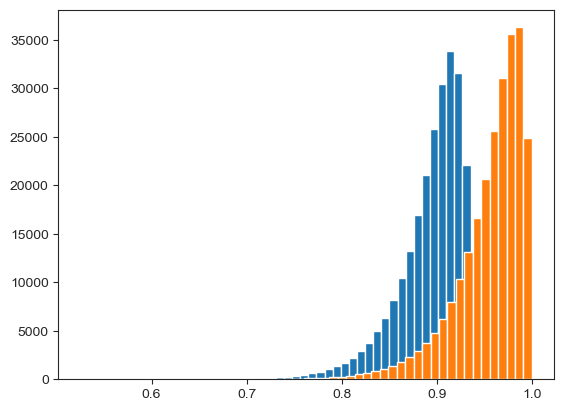

In [62]:
plt.hist(pp_SPV_P/max_spv_cash_flows,bins=50)
plt.hist(SPV_P/max_spv_cash_flows,bins=50)
            

In [63]:
tmp, tranches_pp = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(pp_SPV_P, def_prob/100)
    if i == 0 : tranches_pp[i] = np.quantile(pp_SPV_P, def_prob/100)
    else: tranches_pp[i] = np.quantile(pp_SPV_P, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches_pp[i] = np.quantile(pp_SPV_P, 1) - tmp[i-1].sum(axis=0)

In [64]:
tranches_pp

array([6752.56162935,   31.2153885 ,  115.3956283 ,  336.20343599,
        411.26578818,  296.57616819,  801.89094453])

In [65]:
tranches

array([7233.12392595,   32.55366926,  125.58519927,  358.08993904,
        442.005521  ,  317.878967  ,  671.06262338])

# Cash Flows to each Tranche

In [66]:
pd.DataFrame({'Cash Flows':tranches_pp,'Sum':tranches_pp.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,6752.561629,6752.561629
AA,31.215389,6783.777018
A,115.395628,6899.172646
BBB,336.203436,7235.376082
BB,411.265788,7646.641870
B,296.576168,7943.218039
Equity,801.890945,8745.108983


In [67]:
pd.DataFrame({'Cash Flows':tranches,'Sum':tranches.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,7233.123926,7233.123926
AA,32.553669,7265.677595
A,125.585199,7391.262794
BBB,358.089939,7749.352734
BB,442.005521,8191.358255
B,317.878967,8509.237222
Equity,671.062623,9180.299845


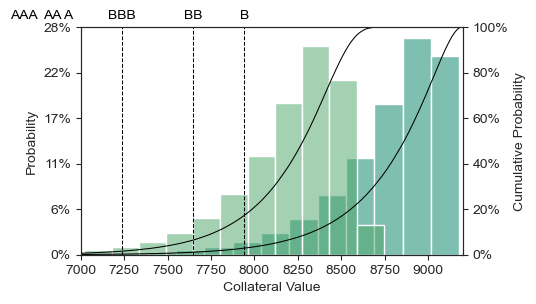

In [68]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P
simulations_pp = pp_SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=0.5)
ax = sns.histplot(data=simulations_pp, bins=25, color=palette(75), stat='probability', alpha=0.5)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations_pp, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
ax2 = sns.ecdfplot(data=simulations_pp, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [69]:
pp_SPV_P_small = np.random.RandomState(1234).choice(pp_SPV_P,size=2500)
pp_M_small = np.random.RandomState(1234).choice(pp_M,size=2500)

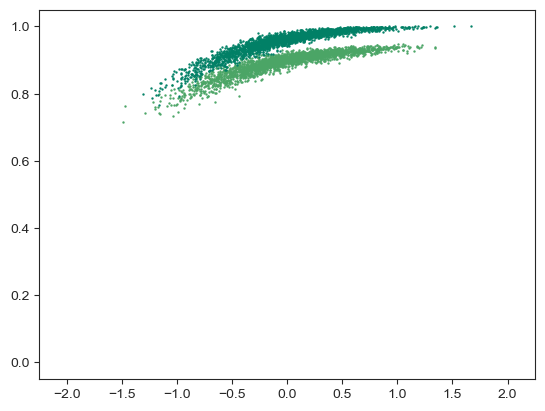

In [70]:
plt.scatter(x=pp_M_small/ttm, y = pp_SPV_P_small/max_spv_cash_flows, s = 0.5, color=palette(75))
plt.scatter(x=scatter_data['Market Factor'], y = scatter_data['SPV'], s = 0.5, color=palette(1))
plt.ylim([-0.05,1.05])
plt.xlim([-2.25,2.25])
plt.savefig('hallo.png')

Data for scatter plots

In [71]:
SPV_P_pp_small = np.random.RandomState(1234).choice(pp_SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(pp_M,size=2500)

In [72]:
scatter_data2 = pd.DataFrame({'SPV':SPV_P_pp_small/ max_spv_cash_flows,
                             'Market Factor':M_small / ttm,
                             'AAA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[0]/ tranches_pp[0],
                             'AA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[1]/ tranches_pp[1],
                             'A':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[2] / tranches_pp[2],
                             'BBB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[3] / tranches_pp[3],
                             'BB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[4] / tranches_pp[4],
                             'B':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[5] / tranches_pp[5],
                             'Equity':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[6]/ tranches_pp[6]})
scatter_data2

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.928588,0.052765,1.0,1.0,1.0,1.0,1.0,1.0,0.725163
1,0.918883,0.480935,1.0,1.0,1.0,1.0,1.0,1.0,0.614058
2,0.912871,0.372519,1.0,1.0,1.0,1.0,1.0,1.0,0.545230
3,0.901015,-0.091125,1.0,1.0,1.0,1.0,1.0,1.0,0.409494
4,0.919537,0.408927,1.0,1.0,1.0,1.0,1.0,1.0,0.621543
...,...,...,...,...,...,...,...,...,...
2495,0.915463,0.438594,1.0,1.0,1.0,1.0,1.0,1.0,0.574900
2496,0.905461,0.085152,1.0,1.0,1.0,1.0,1.0,1.0,0.460399
2497,0.920453,0.302135,1.0,1.0,1.0,1.0,1.0,1.0,0.632027
2498,0.877126,-0.356956,1.0,1.0,1.0,1.0,1.0,1.0,0.136010


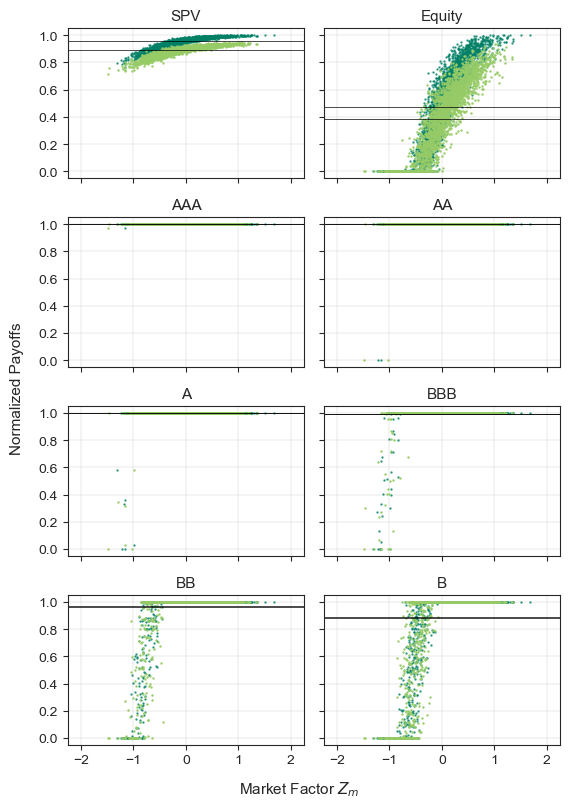

In [73]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1),alpha=0.75)
    axs[i,j].scatter(x=scatter_data2['Market Factor'], y = scatter_data2[tranche], s= 0.5, color=palette(150))
    axs[i,j].set_title(tranche, size=11)
    
    axs[i,j].axhline(scatter_data[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    axs[i,j].axhline(scatter_data2[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

#fig.savefig("Payoffs.pdf", bbox_inches='tight', format='pdf')

plt.show()

In [74]:
initial_market_value_prepayment = mv_call * J

In [75]:
prepay_tab = DefTable[[ttm]].copy()
prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
prepay_tab['Face Value'] = (np.quantile(pp_SPV_P, prepay_tab['Default Probability']/100) / initial_market_value_prepayment) * 100
prepay_tab

,Default Probability,Face Value
AAA,0.27,98.725617
AA,0.30,99.182001
A,0.46,100.869139
BBB,1.54,105.784591
BB,6.43,111.797490
B,17.35,116.133572


In [76]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value_prepayment * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 134.22


In [77]:
for rating in prepay_tab.index:
    prepay_tab.loc[rating, 'Market Value'] = (np.minimum(pp_SPV_Q,
                                                         np.quantile(pp_SPV_P,
                                                                     prepay_tab.loc[rating, 'Default Probability']/100
                                                                    )).mean() * np.exp(-rf*ttm) / initial_market_value_prepayment) * 100

Preliminary table before tranching

In [78]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,98.73,82.68
AA,0.30,99.18,83.05
A,0.46,100.87,84.39
BBB,1.54,105.78,88.11
BB,6.43,111.80,92.04
B,17.35,116.13,94.11


Tranching

In [79]:
prepay_tab.loc[:,'Face Value':'Market Value'] = prepay_tab.loc[:,'Face Value':'Market Value'] - prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
prepay_tab.loc['AAA','Face Value'] = (np.quantile(pp_SPV_P, prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value_prepayment) * 100
prepay_tab.loc['AAA','Market Value'] = (np.minimum(pp_SPV_Q, np.quantile(pp_SPV_P, prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value_prepayment) * 100
prepay_tab['Yield'] = ott.zero_yield(prepay_tab['Market Value'], prepay_tab['Face Value'], ttm) * 100
prepay_tab.loc['Equity','Market Value'] = 100 - prepay_tab['Market Value'].sum(axis=0)

In [80]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,98.73,82.68,3.55
AA,0.30,0.46,0.37,4.43
A,0.46,1.69,1.34,4.63
BBB,1.54,4.92,3.73,5.54
BB,6.43,6.01,3.93,8.53
B,17.35,4.34,2.07,14.80
Equity,NaN,NaN,5.89,NaN


In [330]:
ott.zero_yield(86.64,98.73,ttm)

0.026125449786124622

Comparison with no prepayment case

In [331]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


<AxesSubplot:ylabel='Probability'>

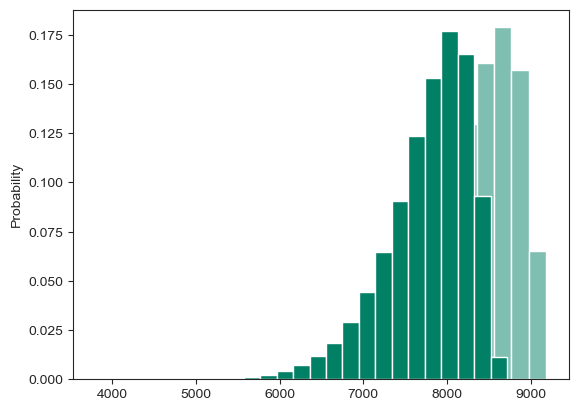

In [264]:
sns.histplot(data=SPV_Q, bins=25, color=palette(1), stat='probability', alpha=0.5)
sns.histplot(data=pp_SPV_Q, bins=25, color=palette(1), stat='probability', alpha=1)